# INF421 — Path Planning Algorithms

**Membres**

- KAMDEM POUOKAM Ivann Harold — **PC**
- NGANTA Pacifique — **PC**

### Installation du projet

In [1]:
!pip install uv

'pip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [2]:
import os

if not os.path.exists("src/random_explorer"):
    !uv pip install git+https://www.github.com/KpihX/random-explorer.git
else:
    !uv pip install -e .

Resolved 55 packages in 811ms
   Building random-explorer @ file:///D:/TD%20Polytechni/random-explorer
      Built random-explorer @ file:///D:/TD%20Polytechni/random-explorer
Prepared 1 package in 45ms
Uninstalled 1 package in 3ms
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 1 package in 696ms
 ~ random-explorer==0.1.0 (from file:///D:/TD%20Polytechni/random-explorer)


In [3]:
from dotenv import load_dotenv
load_dotenv()

# Kaggle credentials for Colab
try:
    from google.colab import userdata
    os.environ["KAGGLE_API_TOKEN"] = userdata.get('KAGGLE_API_TOKEN')
except:
    pass

### Chargement des données

In [4]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np

# Download all scenarios
SCENARIOS = {}
for i in range(5):
    file = f"scenario{i}.txt"
    path = kagglehub.dataset_download(
        handle="ivannkamdem/random-explorer",
        path=file,
    )
    SCENARIOS[f"scenario{i}"] = path
    print(f"Loaded: {file} -> {path}")

# Default scenario for tests
file_path = SCENARIOS["scenario4"]

d:\TD Polytechni\random-explorer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded: scenario0.txt -> C:\Users\pacifique\.cache\kagglehub\datasets\ivannkamdem\random-explorer\versions\1\scenario0.txt
Loaded: scenario1.txt -> C:\Users\pacifique\.cache\kagglehub\datasets\ivannkamdem\random-explorer\versions\1\scenario1.txt
Loaded: scenario2.txt -> C:\Users\pacifique\.cache\kagglehub\datasets\ivannkamdem\random-explorer\versions\1\scenario2.txt
Loaded: scenario3.txt -> C:\Users\pacifique\.cache\kagglehub\datasets\ivannkamdem\random-explorer\versions\1\scenario3.txt
Loaded: scenario4.txt -> C:\Users\pacifique\.cache\kagglehub\datasets\ivannkamdem\random-explorer\versions\1\scenario4.txt


---

## Partie 3 : Particle Swarm Optimization (PSO)

---

### Question 1 : Initialisation de l'environnement

On implémente une classe `Environment` qui :
1. Parse le fichier de scénario (format décrit dans le README)
2. Valide les données (obstacles dans les limites, positions start/goal valides)
3. Fournit une méthode `is_collision(point)` pour la détection de collision

**Choix d'implémentation :**
- Les obstacles sont stockés comme tuples `(x, y, width, height)`
- La validation vérifie que start/goal ne sont pas dans un obstacle
- Les bordures des obstacles sont considérées comme collisions

In [5]:
from random_explorer import Environment

env = Environment(file_path)

print(f"Environment: {env.x_max} x {env.y_max}")
print(f"Start: {env.start}")
print(f"Goal: {env.goal}")
print(f"Number of obstacles: {len(env.obstacles)}")

Environment: 1000.0 x 1000.0
Start: (0.0, 0.0)
Goal: (1000.0, 1000.0)
Number of obstacles: 11


### Question 2 : Visualisation de l'environnement

La méthode `plot_environment()` affiche :
- Les limites de l'environnement
- Les obstacles (rectangles noirs)
- Le point de départ (cercle vert)
- Le point d'arrivée (croix rouge)
- Optionnellement un chemin (ligne bleue)

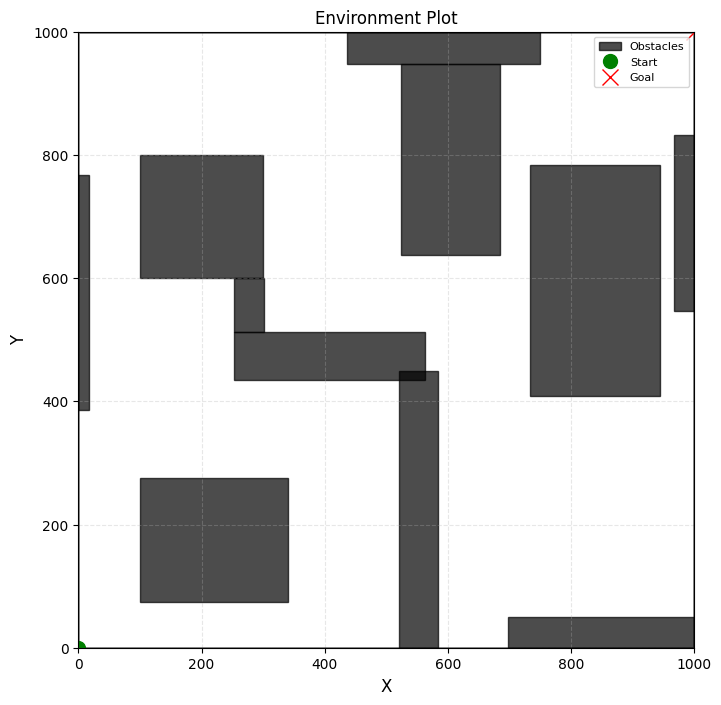

In [6]:
fig, ax = env.plot_environment()
plt.show()

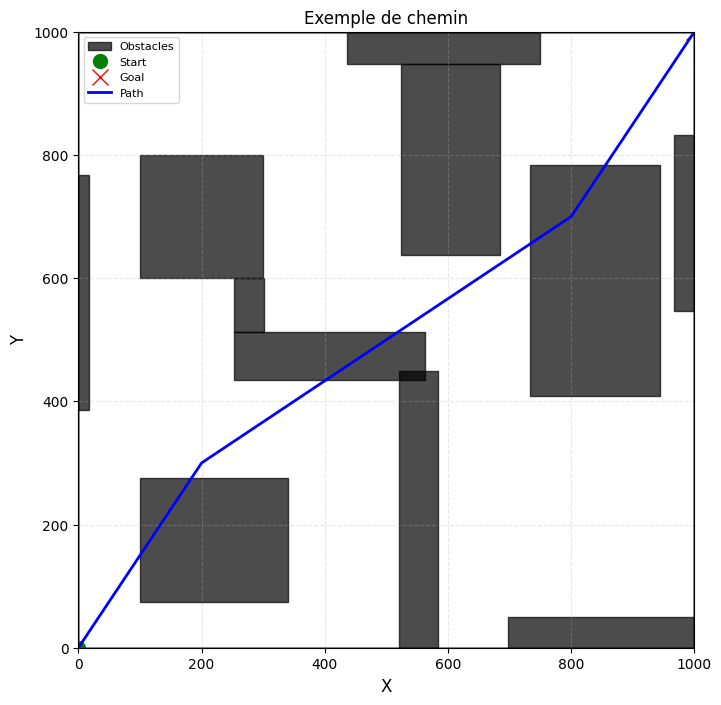

In [7]:
example_path = [(0, 0), (200, 300), (500, 500), (800, 700), (1000, 1000)]
fig, ax = env.plot_environment(path=example_path, title="Exemple de chemin")
plt.show()

### Question 3 : Définition des particules, fonction de fitness et structure de données

**1. Définition d'une particule**

Dans le contexte de la planification de trajectoire, une particule représente **un chemin complet candidat**, modélisé par $N$ waypoints intermédiaires :

$$u_s \rightarrow w_1 \rightarrow w_2 \rightarrow ... \rightarrow w_N \rightarrow u_d$$

**2. Fonction de Fitness**

$$f(x_i) = \text{Longueur}(x_i) + \text{Pénalité}(x_i)$$

**3. Structure de données (NumPy)**

- **Positions $X$** : Matrice $(S, N, 2)$
- **Vitesses $V$** : Matrice $(S, N, 2)$
- **Meilleurs locaux $P_{best}$** : Matrice $(S, N, 2)$
- **Meilleur global $G_{best}$** : Matrice $(N, 2)$

### Question 4 : Méthode de détection de collision

Nous avons implémenté deux méthodes de détection de collision, unifiées par une même formule de pénalité :

**Formule unifiée :**
$$\text{Fitness}(x_i) = L_{path} + P_{base} \cdot \mathbb{1}_{\{C > 0\}} + P_{collision} \cdot C$$

Où :
- $L_{path}$ = longueur géométrique du chemin
- $C$ = métrique de collision (dépend du mode)
- $P_{base}$ = pénalité de base si collision (ex: 1000)
- $P_{collision}$ = pénalité par unité de collision (ex: 100)

---

**Mode Hard (échantillonnage) :**

Échantillonner $p$ points le long de chaque segment et compter le nombre de segments en collision.

$$C_{hard} = \sum_{j=1}^{N+1} \mathbb{1}_{\{\text{segment}_j \text{ en collision}\}}$$

*Simple mais approximatif (dépend de la résolution d'échantillonnage).*

---

**Mode Soft (intersection géométrique) :**

Calcul exact de la longueur d'intersection segment-obstacle via l'algorithme de clipping de Liang-Barsky.

$$C_{soft} = \sum_{j=1}^{N+1} \sum_{k=1}^{M} \text{overlap}(\text{segment}_j, \text{obstacle}_k)$$

*Plus précis : pénalise proportionnellement à la "profondeur" de pénétration.*

### Question 5 : Pseudo-code de l'algorithme PSO

**Note :** L'implémentation supporte les deux modes (`soft_mode=True/False`).  
La fonction `Fitness()` utilise la formule unifiée décrite en Q4.

---

```
Algorithme PSO_PathPlanning

// Initialisation
Pour i = 1..S:
    // Init de chaque particule
    X[i] = N points aléatoires dans [0, x_max] * [0, y_max]
    V[i] = [[0, 0]] * N
    P_best[i], P_best_score[i] = X[i], +∞
    G_best, G_best_score = None, +∞

// Boucle principale
Pour k = 1 à max_iter :
    // Évaluation
    Pour chaque particule i :
        score = Fitness(X[i])
        Si score < P_best_score[i] : 
            P_best_score[i] = score
            P_best[i] = copy(X[i])
        
            Si score < G_best_score : 
                G_best_score  = score
                G_best = copy(X[i])
    
    // Mise à jour cinématique
    // r1, r2 = matrices aléatoires de forme (S, N, 2) avec valeurs dans [0, 1]
    r1 = Random(0, 1, taille=(S, N, 2))
    r2 = Random(0, 1, taille=(S, N, 2))
    V = w*V + c1*r1*(P_best - X) + c2*r2*(G_best - X)
    X = Clip(X + V, bornes)

Retourner [Start] + G_best + [Goal]
```

### Question 6 : Analyse de complexité

**Notations :**
- $K$ : nombre d'itérations
- $S$ : nombre de particules
- $N$ : nombre de waypoints par particule (donc $N+1$ segments)
- $M$ : nombre d'obstacles

---

**Mode Soft (intersection géométrique exacte) :**

1. **Calcul de la longueur du chemin :**
   - Pour chaque particule : $(N+1)$ segments → $O(N)$ opérations
   - Pour toutes les particules : $O(S \cdot N)$

2. **Calcul de la pénalité (cœur de la complexité) :**
   - Pour chaque segment, on calcule l'intersection exacte avec chaque obstacle via intersection paramétrique (clipping de Liang-Barsky) : $O(1)$ par test
   - Par segment : $O(M)$ tests
   - Par particule ($N+1$ segments) : $O(N \cdot M)$
   - Pour toutes les particules : $O(S \cdot N \cdot M)$

3. **Mise à jour des vitesses et positions :**
   - Opérations vectorielles élémentaires sur matrices $(S, N, 2)$ : $O(S \cdot N)$

**Complexité par itération (soft) :** $O(S \cdot N \cdot M)$ *(dominée par l'évaluation fitness)*

**Complexité totale (soft) :** $\boxed{O(K \cdot S \cdot N \cdot M)}$

---

**Mode Hard (échantillonnage) — en comparaison :**

Soit $p$ le nombre de points échantillonnés par segment.

1. **Calcul de la longueur :** identique → $O(S \cdot N)$

2. **Calcul de la pénalité :**
   - Pour chaque segment : échantillonner $p$ points et vérifier chaque point contre $M$ obstacles
   - Test point-dans-rectangle : $O(1)$
   - Par segment : $O(p \cdot M)$
   - Par particule : $O(N \cdot p \cdot M)$
   - Pour toutes les particules : $O(S \cdot N \cdot p \cdot M)$

**Complexité totale (hard) :** $\boxed{O(K \cdot S \cdot N \cdot p \cdot M)}$

---

**Comparaison :**

| Aspect | Mode Soft | Mode Hard |
|--------|-----------|-----------|
| Complexité | $O(K \cdot S \cdot N \cdot M)$ | $O(K \cdot S \cdot N \cdot p \cdot M)$ |
| Facteur supplémentaire | — | $\times p$ |
| Précision | Exacte | Approximative (dépend de $p$) |
| Constantes cachées | Plus élevées (calculs géométriques) | Plus faibles |

**Conclusion :** Le mode soft est asymptotiquement plus efficace ($p$ fois moins d'opérations) **et** plus précis. Le mode hard nécessiterait un $p$ élevé pour être précis, ce qui dégrade ses performances.

### Question 7 : Implémentation

In [8]:
# Top 7 configurations from grid search (scenarios 3 & 4)
# Rank 1: 100% success, avg_length=1894.0
pso_params_1 = {'num_particles': 300, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.8, 'c1': 1.6, 'c2': 1.0}
# Rank 2: 100% success, avg_length=2072.3
pso_params_2 = {'num_particles': 250, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.85, 'c1': 1.4, 'c2': 0.8}
# Rank 3: 100% success, avg_length=3714.8
pso_params_3 = {'num_particles': 300, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.85, 'c1': 1.6, 'c2': 1.4}
# Rank 4: 75% success, avg_length=1848.1
pso_params_4 = {'num_particles': 400, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.7, 'c1': 1.6, 'c2': 0.8}
# Rank 5: 75% success, avg_length=2101.1
pso_params_5 = {'num_particles': 300, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.85, 'c1': 1.0, 'c2': 1.4}
# Rank 6: 75% success, avg_length=2602.8
pso_params_6 = {'num_particles': 400, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.5, 'c1': 1.6, 'c2': 1.6}
# Rank 7: 50% success, avg_length=1551.0
pso_params_7 = {'num_particles': 400, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.7, 'c1': 1.2, 'c2': 1.0}

In [9]:
from random_explorer import PSOPathPlanner

file_path = SCENARIOS["scenario4"]
env = Environment(file_path)

pso_params = pso_params_1.copy()

pso = PSOPathPlanner(env, **pso_params)

path, path_length, score, history = pso.solve(soft_mode=True)
print(f"Score final: {score:.2f}, Longueur: {path_length:.2f}")

PSO: 100%|██████████| 100/100 [00:35<00:00,  2.84it/s]

Score final: 63232.01, Longueur: 2735.96


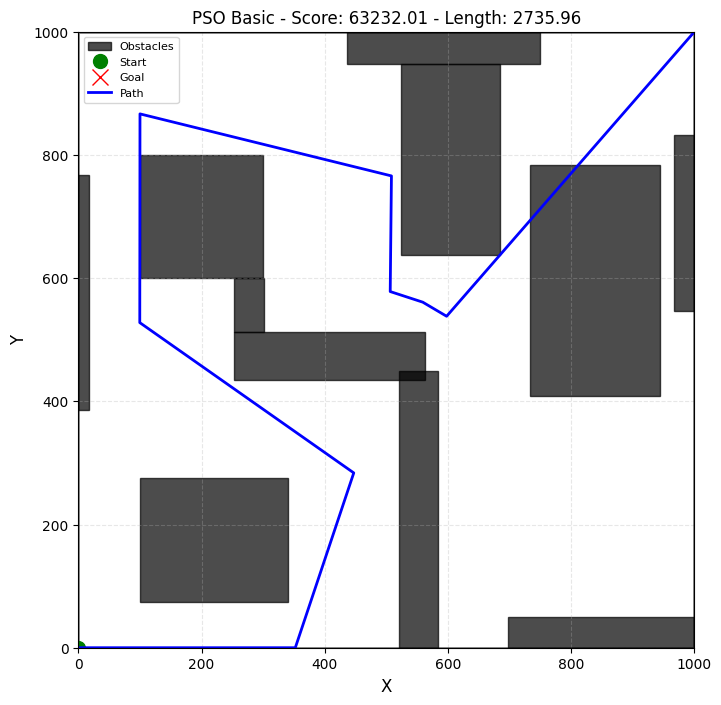

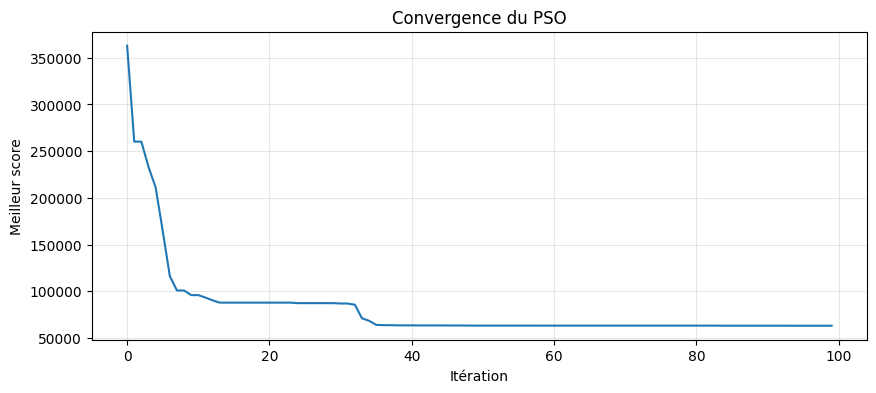

In [10]:
fig, ax = env.plot_environment(path=path, title=f"PSO Basic - Score: {score:.2f} - Length: {path_length:.2f}")

plt.figure(figsize=(10, 4))
plt.plot(history)
plt.xlabel('Itération')
plt.ylabel('Meilleur score')
plt.title('Convergence du PSO')
plt.grid(True, alpha=0.3)
plt.show()

### Question 8 : Performances sur tous les scénarios

**Hyperparamètres retenus :** Meilleure config du grid search (`pso_params_1`)

In [11]:
from random_explorer import Benchmark

benchmark = Benchmark()

PSO_PARAMS = pso_params_1.copy()  # Best config from grid search

print("Benchmark PSO sur tous les scénarios")
print(f"Params: S={PSO_PARAMS['num_particles']}, N={PSO_PARAMS['num_waypoints']}, max_iter={PSO_PARAMS['max_iter']}")
print("="*60)

pso_results = {}
for name, scenario_path in SCENARIOS.items():
    env_test = Environment(scenario_path)
    result = benchmark.run_pso(env_test, params=PSO_PARAMS)
    result.scenario = name
    pso_results[name] = result
    
    valid_str = "✓" if result.is_valid else "✗"
    print(f"{name}: Length={result.path_length:.2f}, Valid={valid_str}, Time={result.cpu_time:.3f}s")

Benchmark PSO sur tous les scénarios
Params: S=300, N=8, max_iter=100


PSO: 100%|██████████| 100/100 [00:04<00:00, 21.70it/s]


scenario0: Length=1443.41, Valid=✓, Time=3.625s


PSO: 100%|██████████| 100/100 [00:04<00:00, 20.17it/s]


scenario1: Length=2000.00, Valid=✓, Time=3.031s


PSO: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


scenario2: Length=1535.84, Valid=✓, Time=12.188s


PSO: 100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


scenario3: Length=1989.85, Valid=✓, Time=16.984s


PSO: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]

scenario4: Length=1735.62, Valid=✗, Time=18.641s


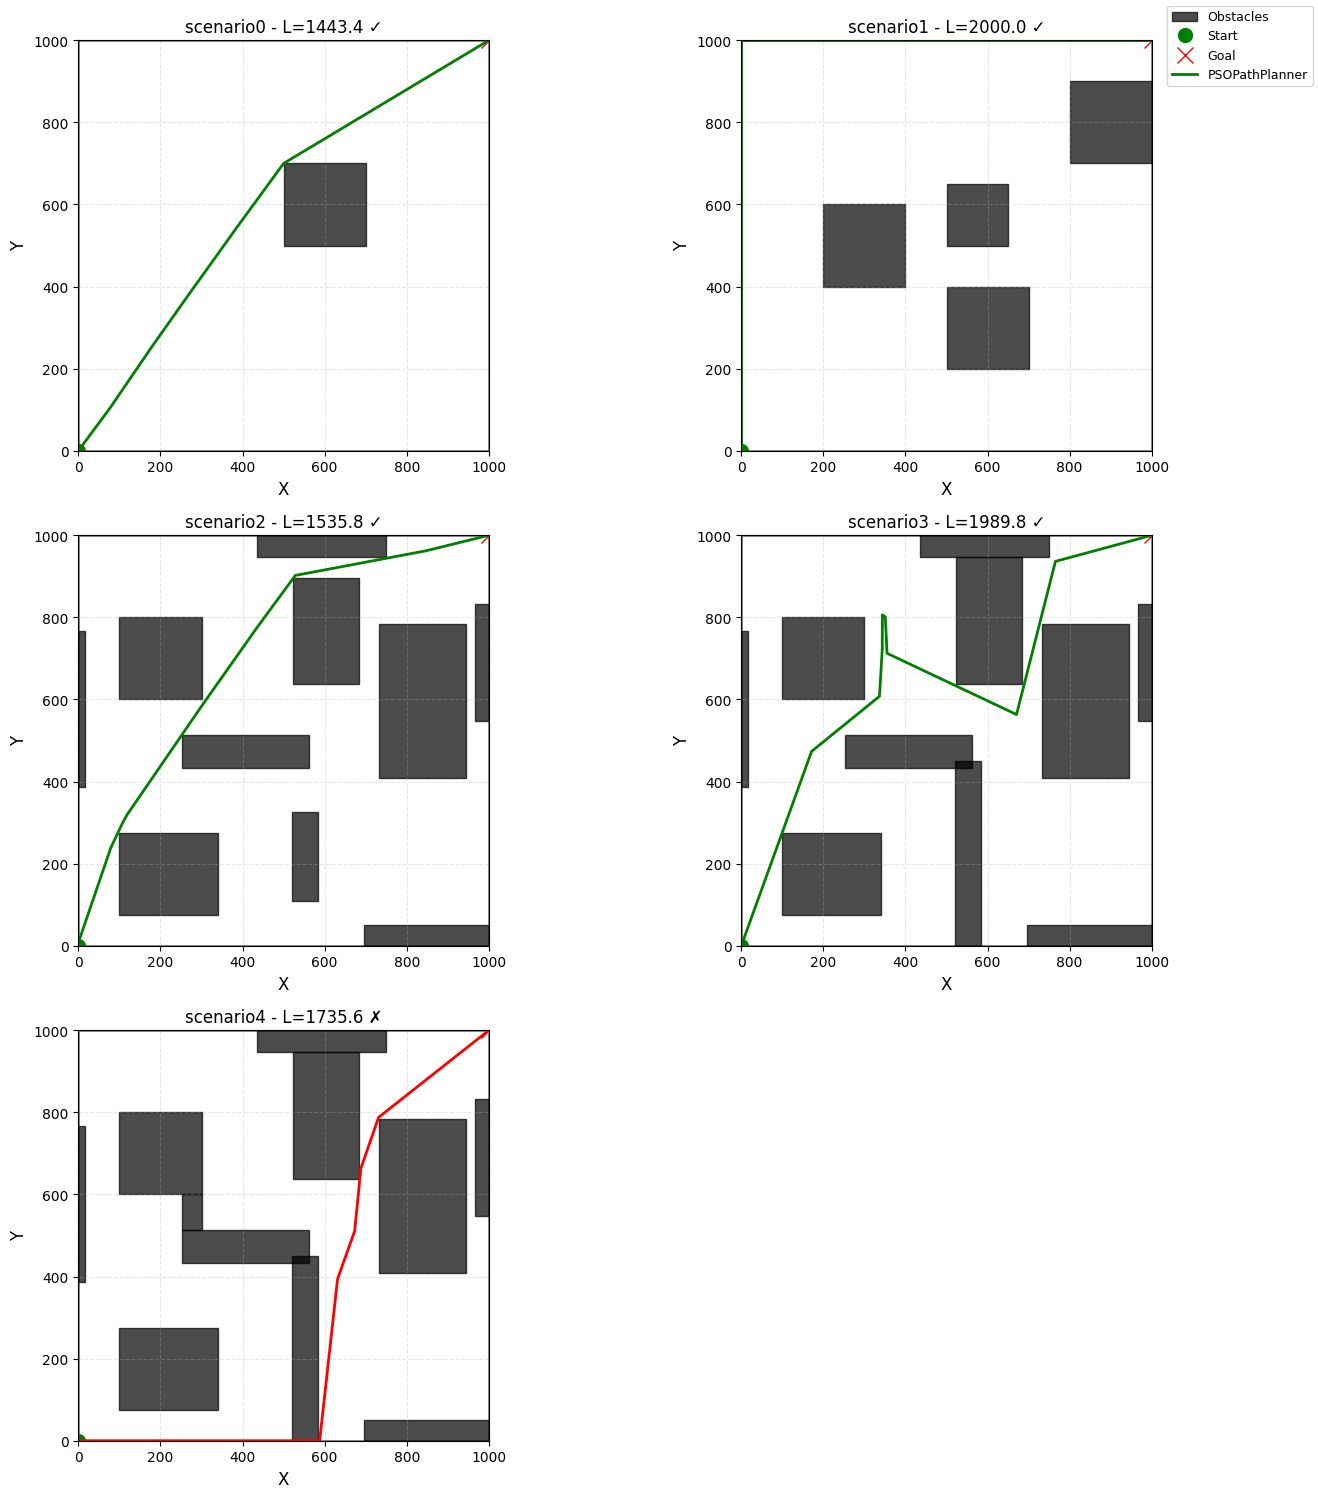

In [12]:
# Visualisation des chemins PSO pour tous les scénarios
envs = {name: Environment(path) for name, path in SCENARIOS.items()}
benchmark.plot_results_grid(pso_results, envs, n_cols=2)
plt.show()

---

## Partie 3.2 : Améliorations du PSO

---

### Question 9 : Random Restart

Réinitialise périodiquement les particules (sauf les élites) pour explorer de nouvelles régions.

**Hyperparamètres :** `restart_frequency=50`, `elite_ratio=0.1`

In [13]:
from random_explorer import PSORestart

file_path = SCENARIOS["scenario4"]
env = Environment(file_path)

pso_params = pso_params_1.copy()
pso_params["num_particles"] = 250
pso_params["w"] = 0.85
pso_params["c1"] = 1.6
pso_params["c2"] = 1.1

pso_restart = PSORestart(
    env, **pso_params,
    restart_frequency=50, elite_ratio=0.4
)

path_restart, length_restart, score_restart, history_restart = pso_restart.solve(soft_mode=True)
print(f"PSO Restart - Score: {score_restart:.2f}, Length: {length_restart:.2f}, Restarts: {pso_restart.num_restarts}")

PSO-Restart: 100%|██████████| 100/100 [00:26<00:00,  3.74it/s]

PSO Restart - Score: 2339.79, Length: 2339.79, Restarts: 1


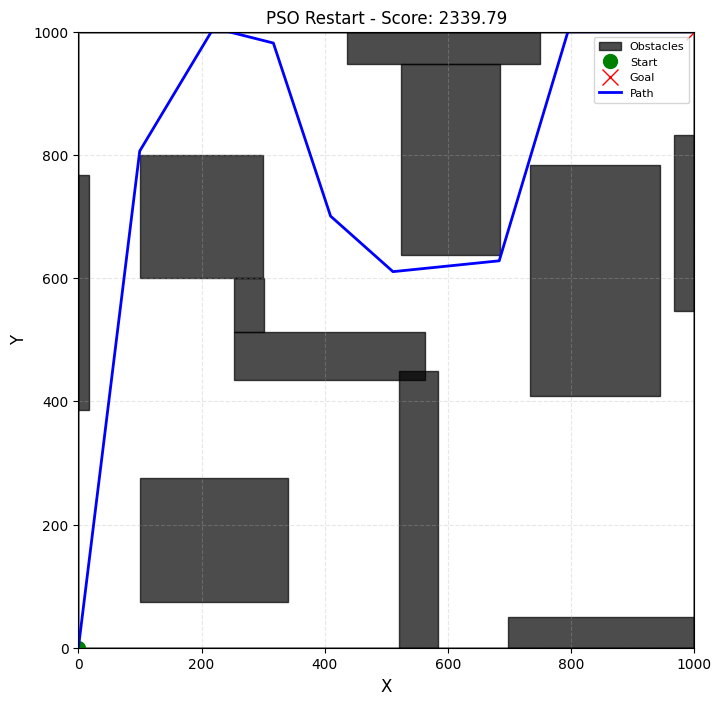

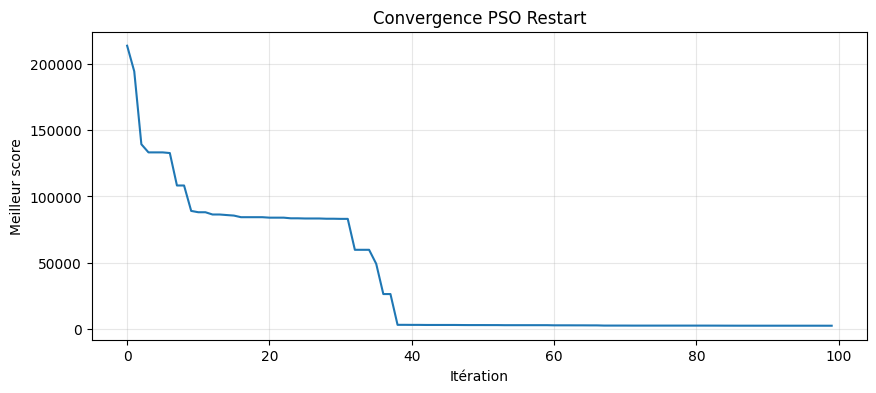

In [14]:
fig, ax = env.plot_environment(path=path_restart, title=f"PSO Restart - Score: {score_restart:.2f}")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_restart)
plt.xlabel('Itération')
plt.ylabel('Meilleur score')
plt.title('Convergence PSO Restart')
plt.grid(True, alpha=0.3)
plt.show()

### Question 10 : Simulated Annealing

Accepte parfois des solutions moins bonnes avec probabilité $p = e^{-\Delta/T}$.

**Hyperparamètres :** `T0=1000`, `beta=0.95`

In [15]:
from random_explorer import PSOSimulatedAnnealing

file_path = SCENARIOS["scenario4"]
env = Environment(file_path)

pso_params = pso_params_1.copy()
pso_params["num_particles"] = 250
pso_params["w"] = 0.85
pso_params["c1"] = 1.6
pso_params["c2"] = 1.0

pso_sa = PSOSimulatedAnnealing(
    env, **pso_params,
    T0=50.0, beta=0.9,
    restart_frequency=50, elite_ratio=0.7
)

path_sa, length_sa, score_sa, history_sa = pso_sa.solve(restart=False, soft_mode=True)
print(f"PSO SA - Score: {score_sa:.2f}, Length: {length_sa:.2f}")

PSO-SA: 100%|██████████| 100/100 [00:27<00:00,  3.66it/s]

PSO SA - Score: 34399.42, Length: 1897.18


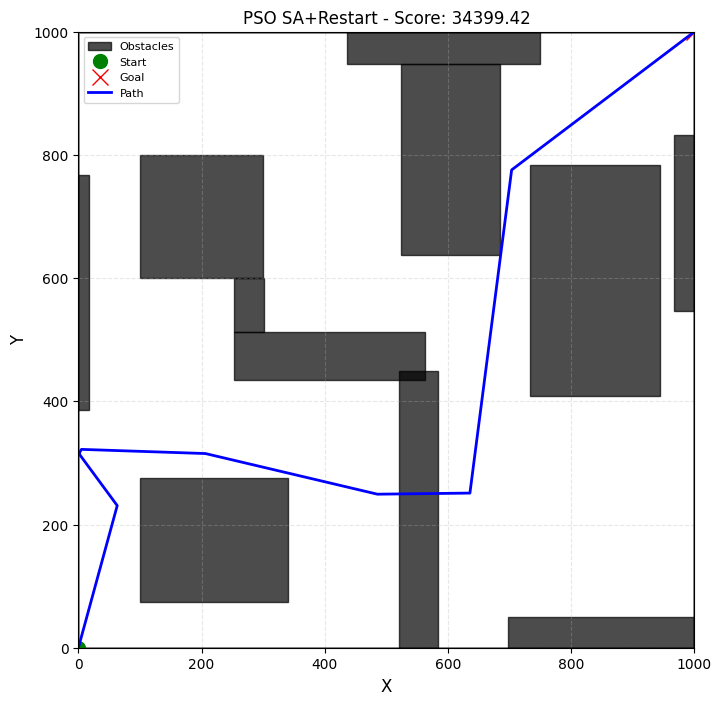

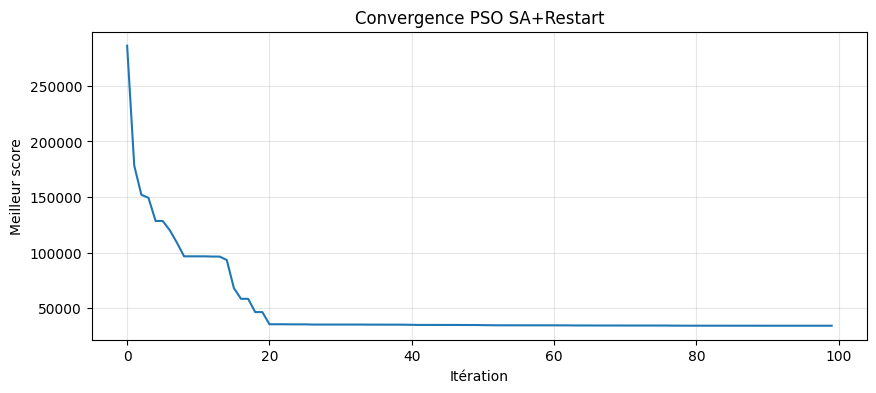

In [16]:
fig, ax = env.plot_environment(path=path_sa, title=f"PSO SA+Restart - Score: {score_sa:.2f}")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_sa)
plt.xlabel('Itération')
plt.ylabel('Meilleur score')
plt.title('Convergence PSO SA+Restart')
plt.grid(True, alpha=0.3)
plt.show()

### Question 11 : Dimensional Learning

Si une particule stagne, améliore son $P_{best}$ dimension par dimension depuis $G_{best}$.

**Hyperparamètre :** `wait_limit=10`

In [17]:
from random_explorer import PSODimensionalLearning

file_path = SCENARIOS["scenario4"]
env = Environment(file_path)

pso_params = pso_params_2.copy()
pso_params["num_waypoints"] = 8
pso_params["c2"] = 1.0

pso_dl = PSODimensionalLearning(
    env, **pso_params,
    wait_limit=50,
    T0=100, beta=0.7, 
    restart_frequency=50, elite_ratio=0.9 
)

path_dl, length_dl, score_dl, history_dl = pso_dl.solve(simulated_annealing=False, restart=False, soft_mode=True)
print(f"PSO DL - Score: {score_dl:.2f}, Length: {length_dl:.2f}")

PSO-DL: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]

PSO DL - Score: 34157.64, Length: 1657.31


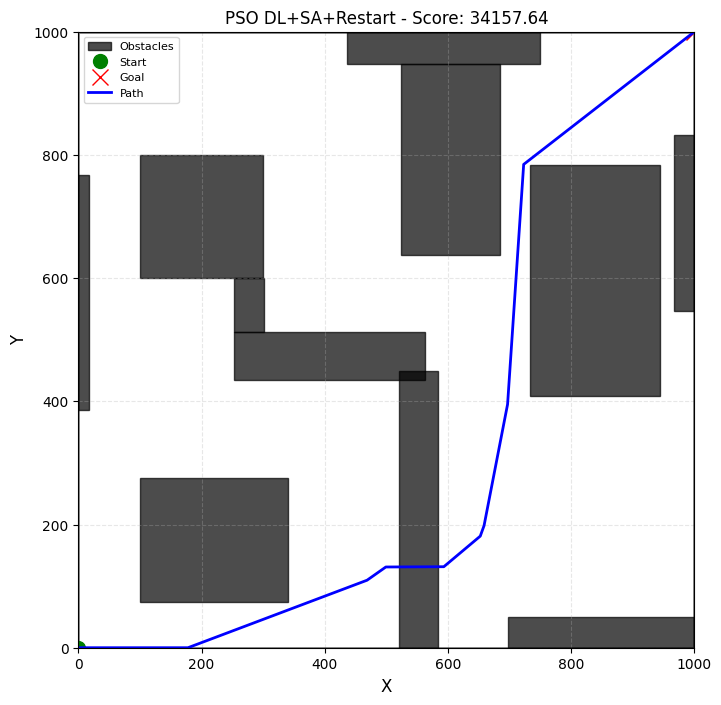

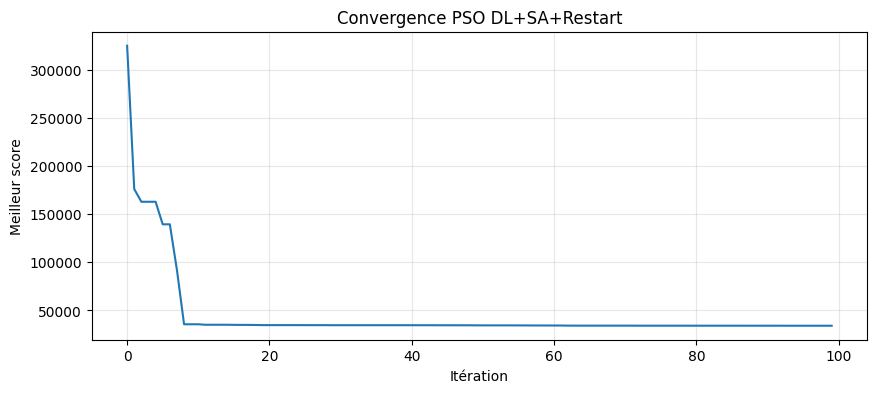

In [18]:
fig, ax = env.plot_environment(path=path_dl, title=f"PSO DL+SA+Restart - Score: {score_dl:.2f}")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_dl)
plt.xlabel('Itération')
plt.ylabel('Meilleur score')
plt.title('Convergence PSO DL+SA+Restart')
plt.grid(True, alpha=0.3)
plt.show()

### Question 12 : Amélioration propre - Adaptive Inertia + Early Stopping

**1. Inertie adaptative :**
Le poids d'inertie décroît linéairement : $w(k) = w_{max} - (w_{max} - w_{min}) \cdot \frac{k}{K}$

Cela favorise l'exploration au début et l'exploitation à la fin.

**2. Arrêt anticipé (Early Stopping) :**
On s'arrête dès qu'un chemin **valide** est trouvé, i.e. quand $\text{score} = \text{longueur}$ (aucune pénalité de collision).

**Justification :**
- PSO n'offre aucune garantie d'optimalité (le plus court chemin)
- Les courbes de convergence montrent de longs paliers (parfois 100+ itérations sans amélioration)
- Dès qu'un chemin valide est trouvé, continuer a peu de chances d'améliorer significativement

**Paramètres supplémentaires :** `dimensional_learning=True/False` pour activer/désactiver le DL.

In [19]:
from random_explorer import PSOAdaptiveInertia

pso_params = pso_params_1.copy()
# pso_params["max_iter"] = 100
pso_params["num_waypoints"] = 9

# Remove 'w' from params since we use w_max/w_min
adaptive_params = {k: v for k, v in pso_params.items() if k != 'w'}

pso_adaptive = PSOAdaptiveInertia(
    env, **adaptive_params,
    w_max=0.9, w_min=0.4,
    wait_limit=25,
    T0=100, beta=0.7, 
    restart_frequency=30, elite_ratio=0.5
)

path_adaptive, length_adaptive, score_adaptive, history_adaptive = pso_adaptive.solve(
    soft_mode=True, 
    restart=False, 
    simulated_annealing=False,
    dimensional_learning=False
)

is_valid = np.isclose(score_adaptive, length_adaptive)
valid_str = "✓ valide" if is_valid else "✗ collision"
print(f"PSO Adaptive - Score: {score_adaptive:.2f}, Length: {length_adaptive:.2f}")
print(f"Itérations: {len(history_adaptive)}/{pso_adaptive.max_iter} ({valid_str})")

PSO-Adaptive: 100%|██████████| 100/100 [00:22<00:00,  4.44it/s]

PSO Adaptive - Score: 34220.01, Length: 1714.80
Itérations: 100/100 (✗ collision)


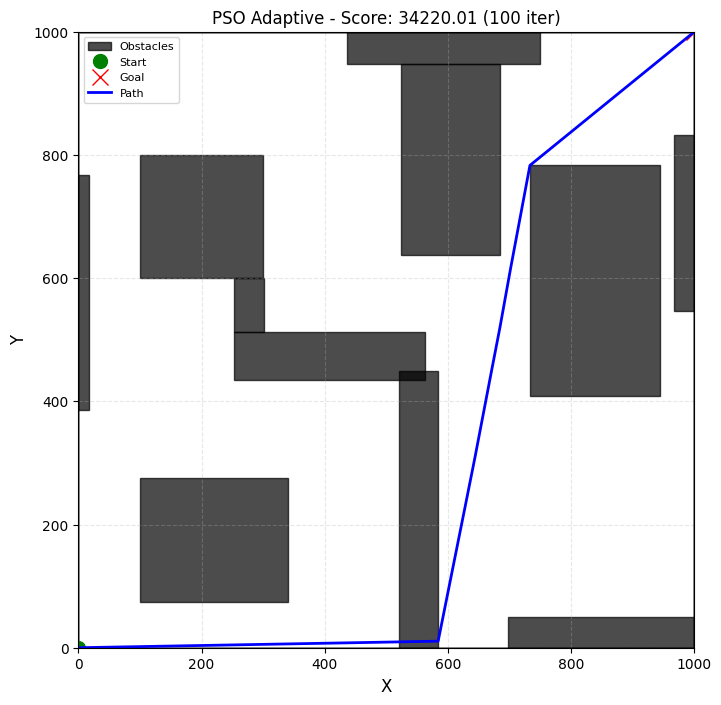

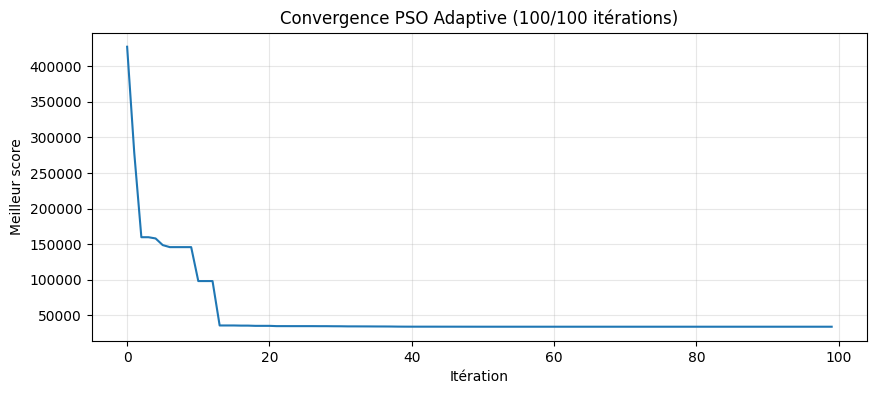

In [20]:
fig, ax = env.plot_environment(path=path_adaptive, title=f"PSO Adaptive - Score: {score_adaptive:.2f} ({len(history_adaptive)} iter)")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_adaptive)
plt.xlabel('Itération')
plt.ylabel('Meilleur score')
plt.title(f'Convergence PSO Adaptive ({len(history_adaptive)}/{pso_adaptive.max_iter} itérations)')
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
# Configuration et benchmark de toutes les variantes PSO sur un scénario ajustable
from random_explorer import Benchmark
import numpy as np

scenario = SCENARIOS["scenario2"]  
env = Environment(scenario)

benchmark = Benchmark()
pso_params = pso_params_1.copy()  # Best config from grid search

# Run all PSO variants with same base params
pso_variant_results = benchmark.run_all_pso_variants(env, base_params=pso_params)

print(f"Benchmark de toutes les variantes PSO sur {scenario}")
print(f"Base params: {pso_params}")
print("=" * 60)

╭───────────────────────────────────────────────── PSO Benchmark ─────────────────────────────────────────────────╮
│ Running PSOPathPlanner with params: {'num_particles': 300, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.8, 'c1': │
│ 1.6, 'c2': 1.0} and solve_kwargs: {'soft_mode': True}                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

PSO: 100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


╭───────────────────────────────────────────────── PSO Benchmark ─────────────────────────────────────────────────╮
│ Running PSORestart with params: {'num_particles': 300, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.8, 'c1':     │
│ 1.6, 'c2': 1.0, 'restart_frequency': 50, 'elite_ratio': 0.4} and solve_kwargs: {'soft_mode': True}              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

PSO-Restart: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


╭───────────────────────────────────────────────── PSO Benchmark ─────────────────────────────────────────────────╮
│ Running PSOSimulatedAnnealing with params: {'num_particles': 300, 'num_waypoints': 8, 'max_iter': 100, 'w':     │
│ 0.8, 'c1': 1.6, 'c2': 1.0, 'T0': 50, 'beta': 0.9, 'restart_frequency': 50, 'elite_ratio': 0.7} and              │
│ solve_kwargs: {'soft_mode': True, 'restart': False}                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

PSO-SA: 100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


╭───────────────────────────────────────────────── PSO Benchmark ─────────────────────────────────────────────────╮
│ Running PSODimensionalLearning with params: {'num_particles': 300, 'num_waypoints': 8, 'max_iter': 100, 'w':    │
│ 0.8, 'c1': 1.6, 'c2': 1.0, 'wait_limit': 50, 'T0': 100, 'beta': 0.7, 'restart_frequency': 50, 'elite_ratio':    │
│ 0.9} and solve_kwargs: {'soft_mode': True, 'simulated_annealing': False, 'restart': False}                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

PSO-DL: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


╭───────────────────────────────────────────────── PSO Benchmark ─────────────────────────────────────────────────╮
│ Running PSOAdaptiveInertia with params: {'num_particles': 300, 'num_waypoints': 8, 'max_iter': 100, 'c1': 1.6,  │
│ 'c2': 1.0, 'w_max': 0.9, 'w_min': 0.4, 'wait_limit': 25, 'T0': 100, 'beta': 0.7, 'restart_frequency': 30,       │
│ 'elite_ratio': 0.5} and solve_kwargs: {'soft_mode': True, 'simulated_annealing': False, 'restart': False,       │
│ 'dimensional_learning': False}                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

PSO-Adaptive:  24%|██▍       | 24/100 [00:08<00:26,  2.82it/s]

Benchmark de toutes les variantes PSO sur C:\Users\pacifique\.cache\kagglehub\datasets\ivannkamdem\random-explorer\versions\1\scenario2.txt
Base params: {'num_particles': 300, 'num_waypoints': 8, 'max_iter': 100, 'w': 0.8, 'c1': 1.6, 'c2': 1.0}


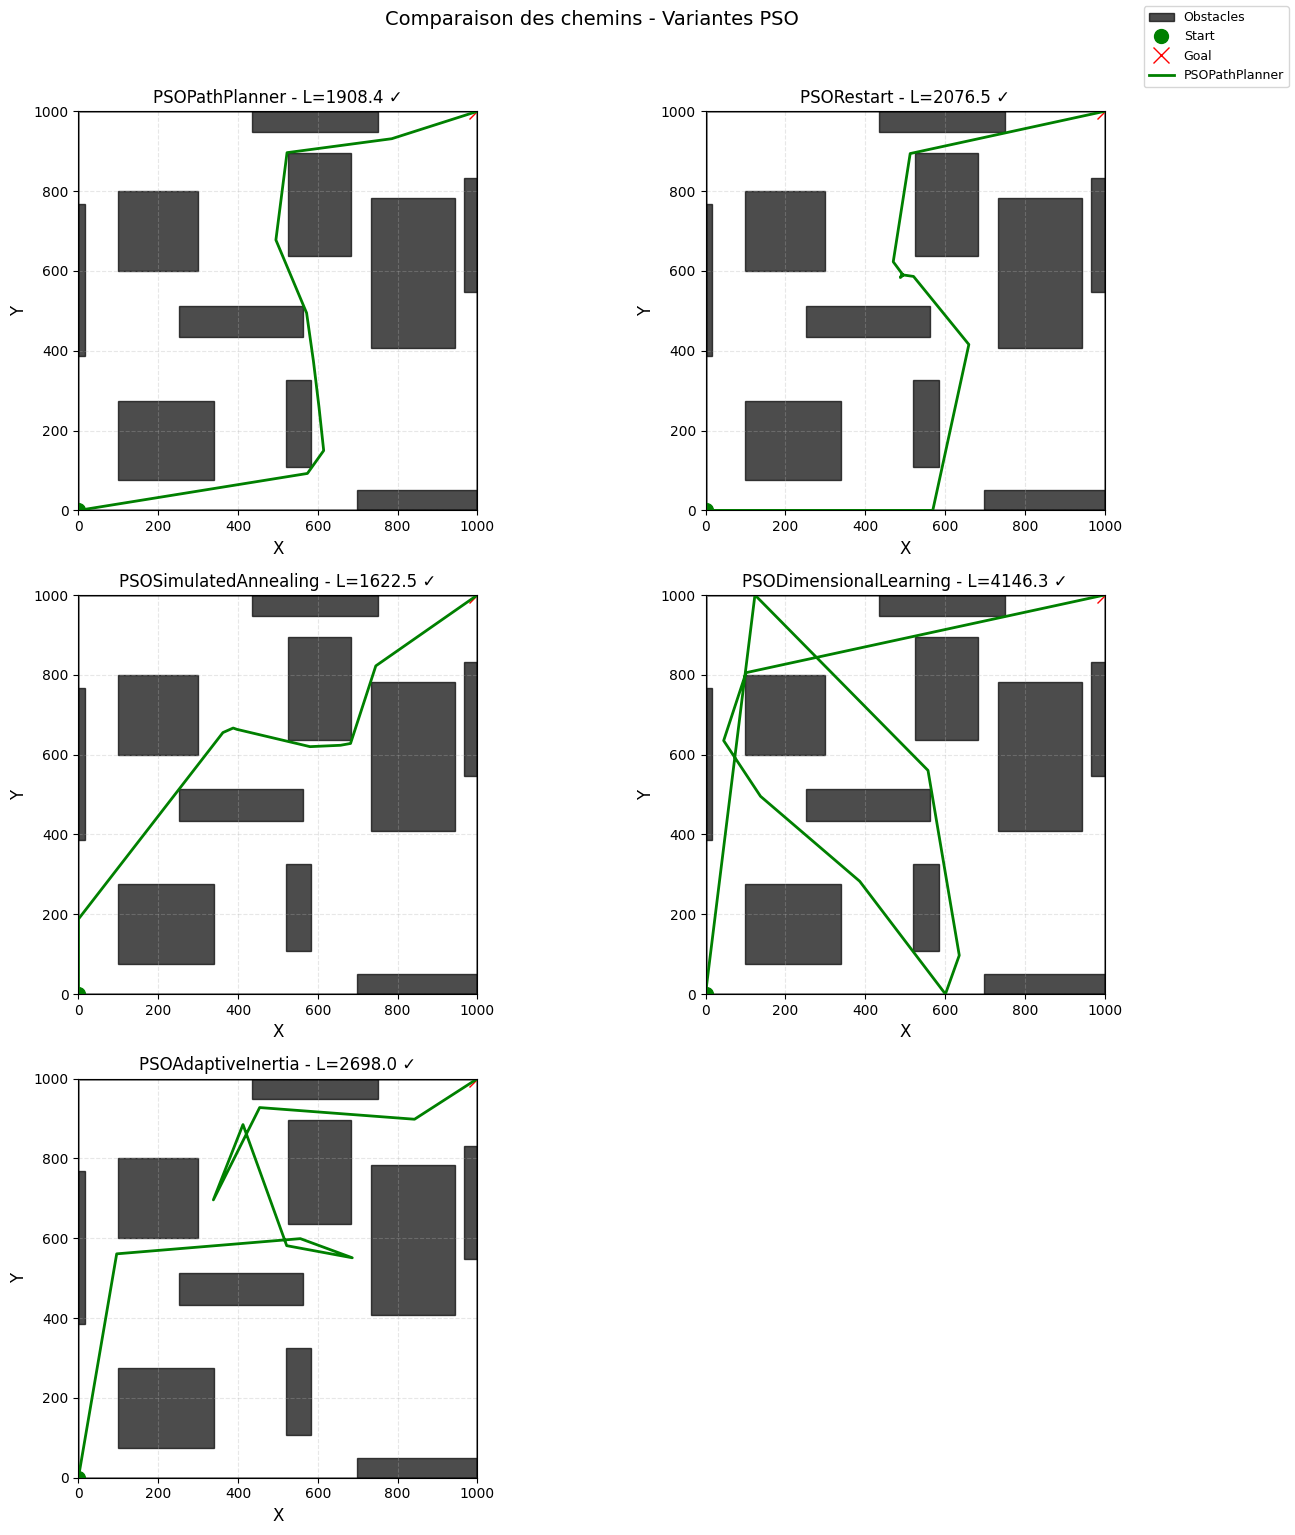

In [22]:
# Visualisation des chemins pour chaque variante 

fig = benchmark.plot_results_grid(
    results=pso_variant_results,
    envs={name: env for name in pso_variant_results.keys()},
    n_cols=2,
)
plt.suptitle("Comparaison des chemins - Variantes PSO", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

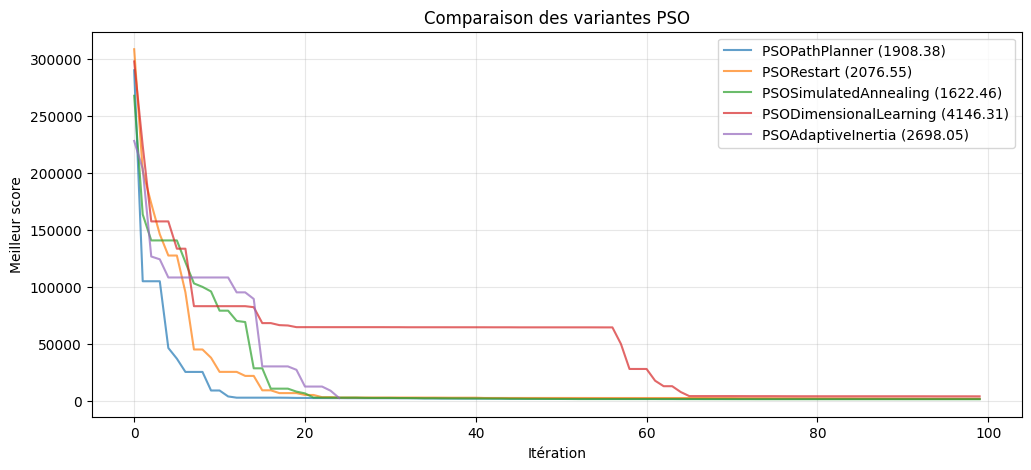

╭───────────────────────────────────────── Comparaison des variantes PSO ─────────────────────────────────────────╮
│ Algorithm                      Score     Length  Valid   Iter   Time (s)                                        │
│ ------------------------------------------------------------------------                                        │
│ PSOSimulatedAnnealing        1622.46    1622.46      ✓    100    20.8125                                        │
│ PSOPathPlanner               1908.38    1908.38      ✓    100    15.3125                                        │
│ PSORestart                   2076.55    2076.55      ✓    100    18.5625                                        │
│ PSOAdaptiveInertia           2698.05    2698.05      ✓     25     6.5469                                        │
│ PSODimensionalLearning       4146.31    4146.31      ✓    100    29.3750                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [23]:
# Comparaison des variantes PSO - Convergence
plt.figure(figsize=(12, 5))
for name, result in pso_variant_results.items():
    if result.history:
        label = f"{name} ({result.score:.2f})" if result.score else name
        plt.plot(result.history, label=label, alpha=0.7)

plt.xlabel('Itération')
plt.ylabel('Meilleur score')
plt.title('Comparaison des variantes PSO')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Récapitulatif des performances PSO (utilisant display_results)
benchmark.display_results(
    list(pso_variant_results.values()),
    title="Comparaison des variantes PSO",
    sort_by='length'
)

---

## Partie 4 : Rapidly-exploring Random Tree (RRT*)

---

### Question 13 : Structure de données pour l'arbre

```python
class Node:
    x: float        # Coordonnée X
    y: float        # Coordonnée Y
    parent: Node    # Nœud parent (None pour la racine)
    cost: float     # Coût cumulé depuis la racine
```

**Arbre :** Liste de nœuds `List[Node]`

### Question 14 : Reconstruction du chemin

```
Fonction ReconstructPath(v):
    chemin = []
    Tant que v ≠ Null :
        chemin.ajouter(v.position)
        v = v.parent
    Retourner chemin.inverser()
```

**Complexité :** $O(h)$ où $h$ est la profondeur du nœud.

### Question 15 : Pseudo-code RRT*

```
Algorithme RRT_Star(Start, Goal, max_iter, δ_s, δ_r, goal_bias)

Entrées:
    Start       : Point de départ
    Goal        : Point d'arrivée
    max_iter    : Nombre maximal d'itérations
    δ_s (delta_s) : Distance maximale de steering (extension)
    δ_r (delta_r) : Rayon de recherche des voisins pour rewiring
    goal_bias   : Probabilité de choisir Goal comme cible (ex: 0.05) ; permets de rendre la convergence rapide, évitant une exploration uniforme de toute la carte

// Initialisation
Arbre = [Node(Start, parent=None, cost=0)]

// Boucle principale
Pour k = 1 à max_iter :

    // Échantillonnage biaisé vers le goal
    r = nombre aléatoire dans [0, 1]
    Si r < goal_bias :
        v_rand = Goal                    // Avec proba goal_bias, on cible le goal
    Sinon :
        v_rand = point aléatoire uniforme dans l'espace
    
    // Trouver le nœud le plus proche
    v_nearest = argmin_{v dans Arbre} distance(v, v_rand)
    
    // Steering : créer un nouveau point vers v_rand
    direction = (v_rand - v_nearest) / ||v_rand - v_nearest||
    distance_to_rand = min(||v_rand - v_nearest||, δ_s)
    v_new = v_nearest + direction * distance_to_rand
    
    // Vérification collision du segment
    Si segment(v_nearest, v_new) sans collision :
    
        // Choose Best Parent : chercher le meilleur parent parmi les voisins
        voisins = {v ∈ Arbre : distance(v, v_new) ≤ δ_r}
        best_parent = v_nearest
        best_cost = v_nearest.cost + distance(v_nearest, v_new)
        
        Pour chaque v ∈ voisins :
            Si segment(v, v_new) sans collision :
                cost_via_v = v.cost + distance(v, v_new)
                Si cost_via_v < best_cost :
                    best_parent = v
                    best_cost = cost_via_v
        
        // Ajouter v_new à l'arbre
        v_new.parent = best_parent
        v_new.cost = best_cost
        Arbre.ajouter(v_new)
        
        // Rewiring : améliorer les voisins si v_new offre un raccourci
        Pour chaque v ∈ voisins, v ≠ best_parent :
            Si segment(v_new, v) sans collision :
                new_cost = v_new.cost + distance(v_new, v)
                Si new_cost < v.cost :
                    v.parent = v_new
                    v.cost = new_cost

// Reconstruction du chemin
Retourner ReconstructPath(nœud le plus proche de Goal)
```

### Question 16 : Complexité d'une itération RRT*

Soit $n$ le nombre de nœuds actuellement dans l'arbre, $M$ le nombre d'obstacles.

#### Détail par étape :

| Étape | Opération | Complexité |
|-------|-----------|------------|
| 1. Échantillonnage | Générer un point aléatoire | $O(1)$ |
| 2. Nearest Neighbor | Trouver le nœud le plus proche (parcours naïf) | $O(n)$ |
| 3. Steering | Calculer `v_new` (opérations vectorielles) | $O(1)$ |
| 4. Collision segment | Tester collision avec $M$ obstacles | $O(M)$ |
| 5. Find Neighbors | Trouver voisins dans rayon $\delta_r$ | $O(n)$ |
| 6. Choose Best Parent | Tester collision pour chaque voisin (pire cas : tous) | $O(n \cdot M)$ |
| 7. Rewiring | Tester et mettre à jour les voisins | $O(n \cdot M)$ |

#### Complexité totale d'une itération :

$$\boxed{O(n \cdot M)}$$

- Le terme dominant est le **rewiring** et le **choose best parent**, car on teste potentiellement la collision de $O(n)$ segments avec $M$ obstacles.

#### Complexité totale sur $K$ itérations :

À l'itération $k$, l'arbre contient au plus $k$ nœuds, donc :

$$\sum_{k=1}^{K} O(k \cdot M) = O(M) \cdot \sum_{k=1}^{K} k = O(M \cdot K^2)$$

$$\boxed{O(K^2 \cdot M)}$$



### Question 17 : Implémentation

In [24]:
from random_explorer import RRTPlanner

scenario = SCENARIOS["scenario4"]  
env = Environment(scenario)

rrt = RRTPlanner(
    env,
    max_iter=2000,
    delta_s=200.0,
    delta_r=200.0,
    goal_bias=0.05,
    goal_tolerance=20.0
)

rrt_path, rrt_length, _ = rrt.solve()

if rrt_path:
    print(f"RRT* - Chemin trouvé! Longueur: {rrt_length:.2f}, Nœuds: {len(rrt.nodes)}")
else:
    print("RRT* - Pas de chemin trouvé")

RRT*: 100%|██████████| 2000/2000 [00:07<00:00, 262.34it/s, best_cost=2037.3]

RRT* - Chemin trouvé! Longueur: 2037.32, Nœuds: 938


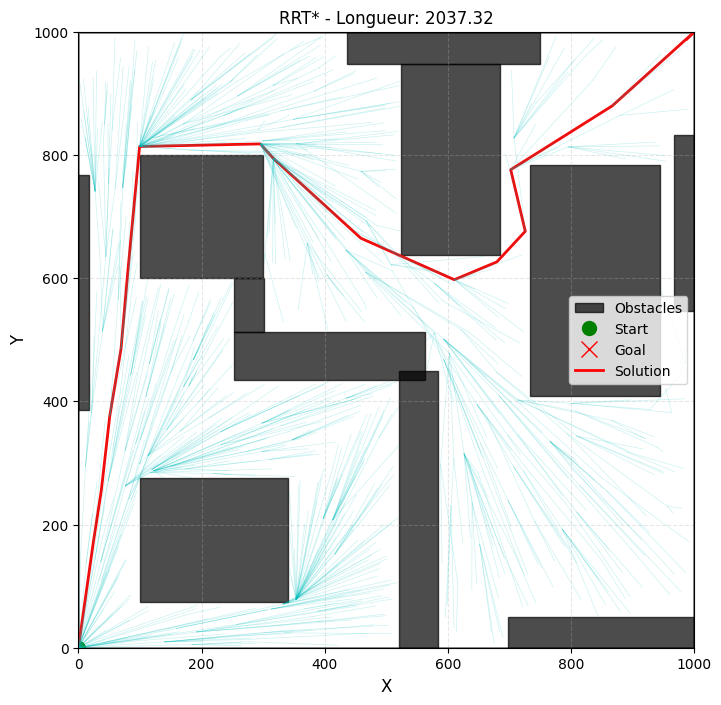

In [25]:
fig, ax = rrt.plot_tree(path=rrt_path, title=f"RRT* - Longueur: {rrt_length:.2f}")
plt.show()

### Question 18 : Performances sur tous les scénarios

In [26]:
RRT_PARAMS = {
    'max_iter': 2000,
    'delta_s': 200.0,
    'delta_r': 200.0,
    'goal_bias': 0.05
}

print(f"Benchmark RRT* sur tous les scénarios (max_iter = {RRT_PARAMS["max_iter"]})")
print("="*60)

rrt_results = {}
for name, scenario_path in SCENARIOS.items():
    env_test = Environment(scenario_path)
    result = benchmark.run_rrt(env_test, False, False, RRT_PARAMS)
    result.scenario = name
    rrt_results[name] = result
    
    valid_str = "✓" if result.is_valid else "✗"
    length_str = f"{result.path_length:.2f}" if result.path_length < float('inf') else "N/A"
    print(f"{name}: Length={length_str}, Valid={valid_str}, Time={result.cpu_time:.3f}s")

Benchmark RRT* sur tous les scénarios (max_iter = 2000)


RRT*: 100%|██████████| 2000/2000 [00:20<00:00, 99.25it/s, best_cost=1446.1] 


scenario0: Length=1446.06, Valid=✓, Time=14.984s


RRT*: 100%|██████████| 2000/2000 [00:16<00:00, 117.96it/s, best_cost=1462.9]


scenario1: Length=1462.85, Valid=✓, Time=13.250s


RRT*: 100%|██████████| 2000/2000 [00:13<00:00, 145.40it/s, best_cost=1525.1]


scenario2: Length=1525.11, Valid=✓, Time=11.047s


RRT*: 100%|██████████| 2000/2000 [00:10<00:00, 182.48it/s, best_cost=1549.1]


scenario3: Length=1549.07, Valid=✓, Time=8.672s


RRT*: 100%|██████████| 2000/2000 [00:12<00:00, 161.95it/s, best_cost=1981.3]

scenario4: Length=1981.32, Valid=✓, Time=8.641s


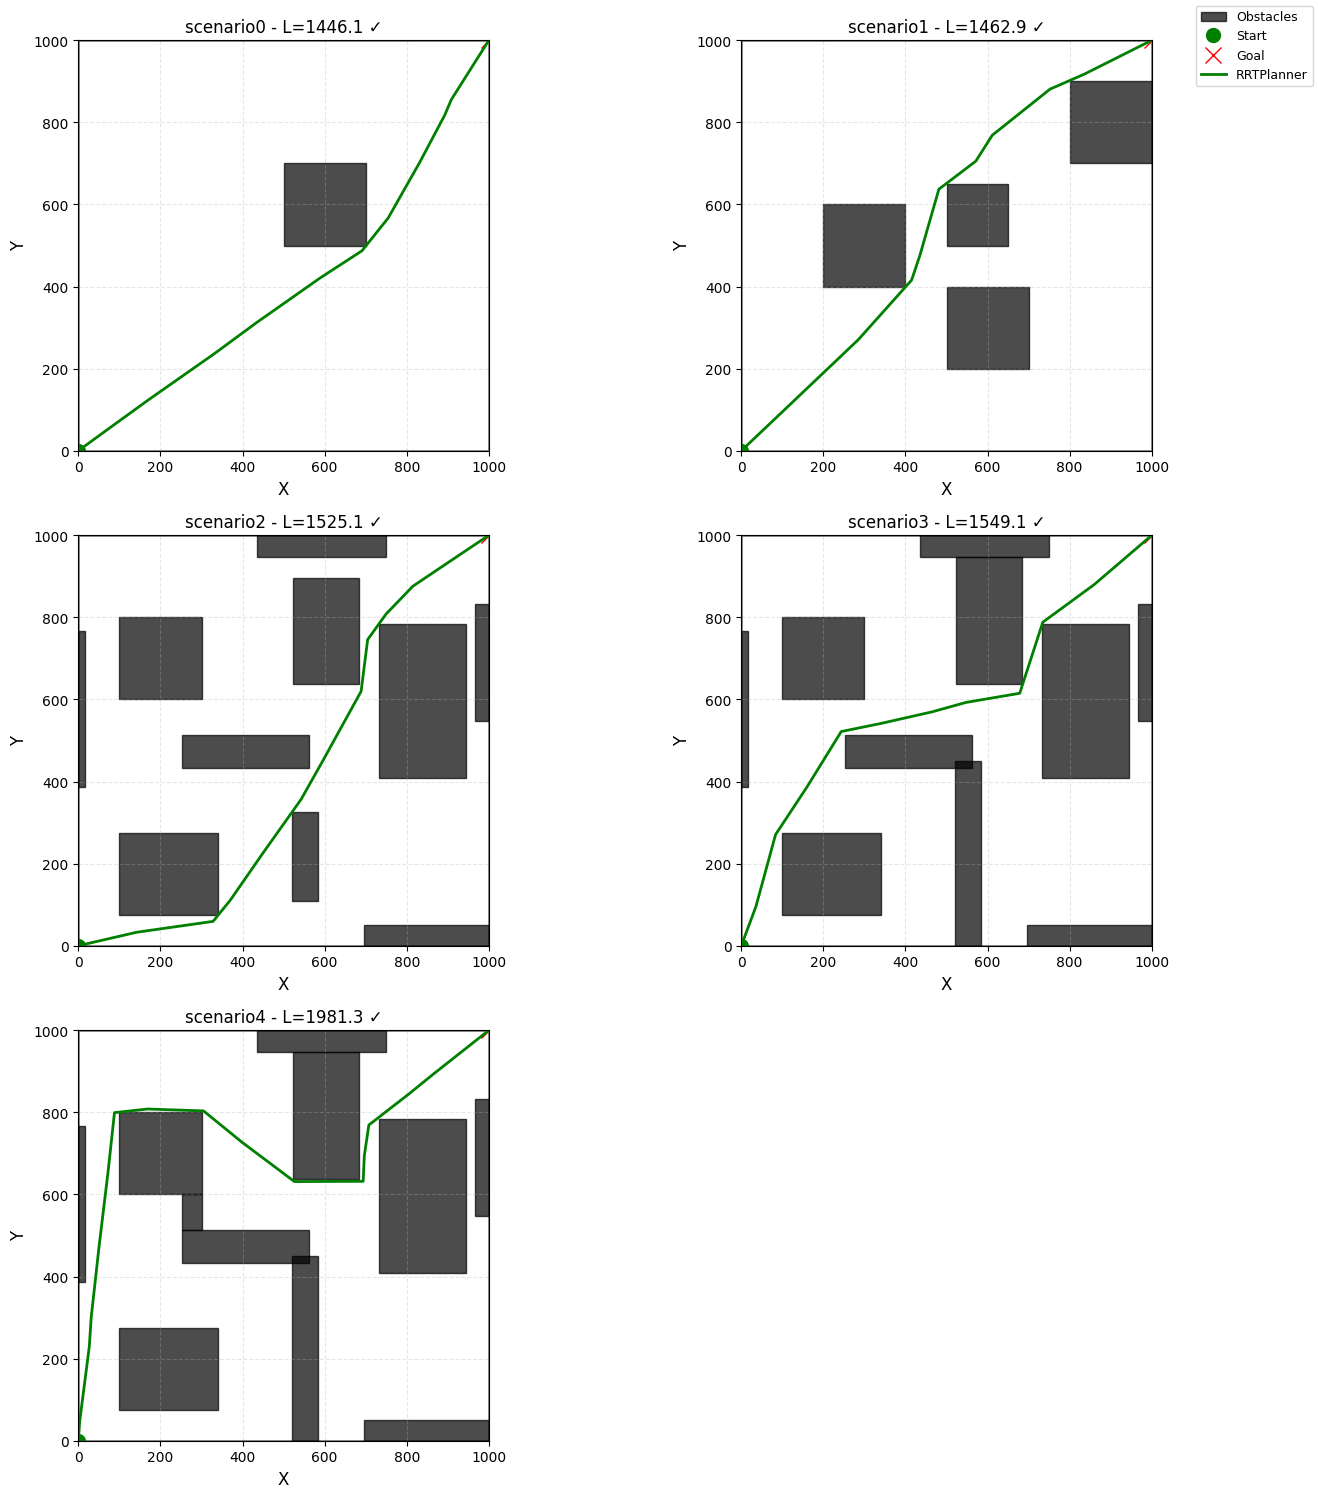

In [27]:
# Visualisation des chemins RRT pour tous les scénarios
envs = {name: Environment(path) for name, path in SCENARIOS.items()}
benchmark.plot_results_grid(rrt_results, envs, n_cols=2)
plt.show()

In [28]:
# Comparaison PSO vs RRT
print("\nComparaison PSO vs RRT*")
print("="*70)
print(f"{'Scénario':<12} {'PSO Length':>12} {'RRT Length':>12} {'PSO Time':>10} {'RRT Time':>10}")
print("-"*70)

for name in SCENARIOS.keys():
    pso_r = pso_results[name]
    rrt_r = rrt_results[name]
    pso_len = f"{pso_r.path_length:.2f}" if pso_r.path_length < float('inf') else "N/A"
    rrt_len = f"{rrt_r.path_length:.2f}" if rrt_r.path_length < float('inf') else "N/A"
    print(f"{name:<12} {pso_len:>12} {rrt_len:>12} {pso_r.cpu_time:>10.3f} {rrt_r.cpu_time:>10.3f}")


Comparaison PSO vs RRT*
Scénario       PSO Length   RRT Length   PSO Time   RRT Time
----------------------------------------------------------------------
scenario0         1443.41      1446.06      3.625     14.984
scenario1         2000.00      1462.85      3.031     13.250
scenario2         1535.84      1525.11     12.188     11.047
scenario3         1989.85      1549.07     16.984      8.672
scenario4         1735.62      1981.32     18.641      8.641


**Conclusion :**

| Aspect | PSO | RRT* |
|--------|-----|------|
| Fiabilité | Variable | Très fiable |
| Paramétrage | Plus complexe | Simple |
<!-- | Temps | Rapide | Plus lent | -->


RRT* est plus robuste pour les environnements complexes, PSO plus rapide sur les cas simples.

### Question 19 : Analyse de complexité de l'optimisation de chemin

**Notations :**
- $n$ : nombre de points dans le chemin à optimiser
- $M$ : nombre d'obstacles dans l'environnement

---

#### **Principe de l'algorithme d'optimisation**

L'algorithme parcourt le chemin et tente de "sauter" directement vers les points les plus éloignés possibles sans collision (inégalité triangulaire).

#### **Analyse de complexité**

**Boucle principale :**
   - Dans le pire cas, on visite chaque point du chemin : $O(n)$ itérations

**Recherche du point le plus loin atteignable :**
   - Pour chaque point courant, on teste les connexions directes vers tous les points suivants
   - Dans le pire cas (aucun raccourci possible) : on teste $(n-1) + (n-2) + ... + 1 = \frac{n(n-1)}{2}$ segments
   - Complexité de cette étape : $O(n^2)$

**Test de collision par segment :**
   - Chaque test `_check_collision()` utilise `evaluate_path_collision()` de l'environnement
   - Cette méthode teste l'intersection du segment avec chaque obstacle : $O(M)$
   - Complexité par test de collision : $O(M)$

**Calcul de la longueur du chemin optimisé :**
   - Parcours de tous les points du chemin optimisé
   - Dans le meilleur cas (chemin très raccourci) : $O(1)$ à $O(\log n)$
   - Dans le pire cas (aucune optimisation) : $O(n)$


#### **Complexités**

**Complexité par optimisation :**

- **Meilleur cas** : 
  - Peu de tests nécessaires, chemin rapidement simplifié
  - $O(n \cdot M)$

- **Cas moyen** : 
  - Quelques raccourcis trouvés, réduction modérée du nombre de tests
  - $O(n^2 \cdot M)$

- **Pire cas** (environnement très contraint, aucun raccourci) : 
  - Test de tous les segments possibles
  - $\boxed{O(n^2 \cdot M)}$

---

#### Complexité totale de l'algorithme RRT* avec optimisation

Si on note :
- $K$ : nombre d'itérations RRT*
- $\delta_r$ : rayon de recherche des voisins
- $n_{\text{tree}}$ : nombre de nœuds dans l'arbre (≈ $K$ en pratique)
- $n_{\text{path}}$ : nombre de points dans le chemin final

**Sans optimisation :**
$$\boxed{O(K \cdot n_{\text{tree}} \cdot M)}$$

**Avec optimisation :**
$$\boxed{O(K \cdot n_{\text{tree}} \cdot M + n_{\text{path}}^2 \cdot M)}$$


#### Benchmark RRT optimization

In [29]:
RRT_PARAMS = {
    'max_iter': 2000,
    'delta_s': 200.0,
    'delta_r': 200.0,
    'goal_bias': 0.05
}

print(f"Benchmark RRT* sur tous les scénarios (max_iter = {RRT_PARAMS["max_iter"]})")
print("="*60)

rrt_opti_results = {}
for name, scenario_path in SCENARIOS.items():
    env_test = Environment(scenario_path)
    result = benchmark.run_rrt(env_test, True, False, RRT_PARAMS)
    result.scenario = name
    rrt_opti_results[name] = result
    
    valid_str = "✓" if result.is_valid else "✗"
    length_str = f"{result.path_length:.2f}" if result.path_length < float('inf') else "N/A"
    print(f"{name}: Length={length_str}, Valid={valid_str}, Time={result.cpu_time:.3f}s")

Benchmark RRT* sur tous les scénarios (max_iter = 2000)


RRT* optimized: 100%|██████████| 2000/2000 [00:24<00:00, 82.92it/s, best_cost=1445.5] 


scenario0: Length=1444.96, Valid=✓, Time=15.953s


RRT* optimized: 100%|██████████| 2000/2000 [00:17<00:00, 117.53it/s, best_cost=1461.3]


scenario1: Length=1459.23, Valid=✓, Time=12.938s


RRT* optimized: 100%|██████████| 2000/2000 [00:13<00:00, 144.17it/s, best_cost=1517.1]


scenario2: Length=1515.50, Valid=✓, Time=10.578s


RRT* optimized: 100%|██████████| 2000/2000 [00:13<00:00, 146.37it/s, best_cost=1554.5]


scenario3: Length=1551.02, Valid=✓, Time=10.359s


RRT* optimized: 100%|██████████| 2000/2000 [00:10<00:00, 184.00it/s, best_cost=2013.0]

scenario4: Length=1998.46, Valid=✓, Time=7.938s


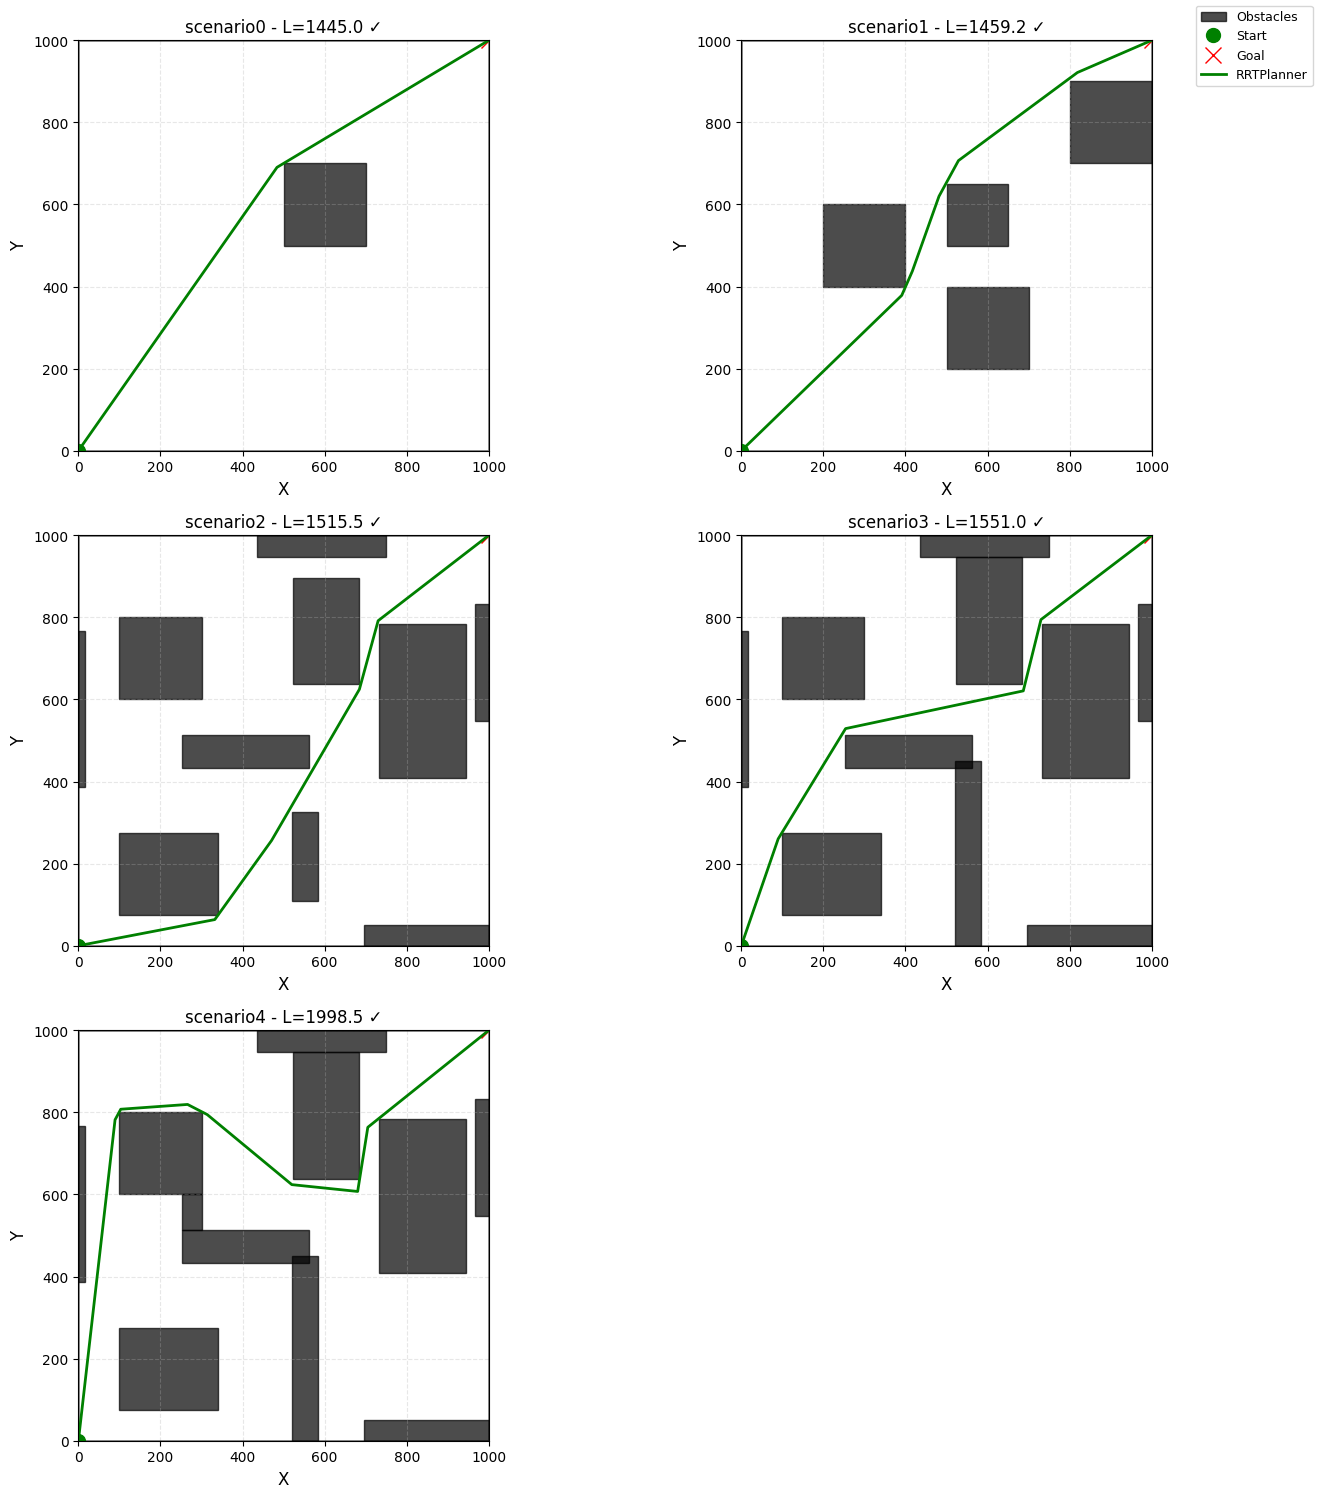

In [34]:
envs = {name: Environment(path) for name, path in SCENARIOS.items()}
benchmark.plot_results_grid(rrt_opti_results, envs, n_cols=2)
plt.show()

In [ ]:
print("\nComparaison PSO vs RRT* vs RRT* optim")
print("="*90)
print(f"{'Scénario':<12} {'PSO Length':>12} {'RRT Length':>12} {'RRT_opti Length':>12} {'PSO Time':>10} {'RRT Time':>10} {'RRT_opti Time':>10}")
print("-"*90)

for name in SCENARIOS.keys():
    pso_r = pso_results[name]
    rrt_r = rrt_results[name]
    rrt_opti_r = rrt_opti_results[name]
    pso_len = f"{pso_r.path_length:.2f}" if pso_r.path_length < float('inf') else "N/A"
    rrt_len = f"{rrt_r.path_length:.2f}" if rrt_r.path_length < float('inf') else "N/A"
    rrt_opti_len = f"{rrt_opti_r.path_length:.2f}" if rrt_opti_r.path_length < float('inf') else "N/A"
    print(f"{name:<12} {pso_len:>12} {rrt_len:>12} {rrt_opti_len:>12} {pso_r.cpu_time:>10.3f} {rrt_r.cpu_time:>10.3f} {rrt_opti_r.cpu_time:>10.3f}")


Comparaison PSO vs RRT*
Scénario       PSO Length   RRT Length RRT_opti Length   PSO Time   RRT Time RRT_opti Time
------------------------------------------------------------------------------------------
scenario0         1443.41      1446.06      1444.96      3.625     14.984     15.953
scenario1         2000.00      1462.85      1459.23      3.031     13.250     12.938
scenario2         1535.84      1525.11      1515.50     12.188     11.047     10.578
scenario3         1989.85      1549.07      1551.02     16.984      8.672     10.359
scenario4         1735.62      1981.32      1998.46     18.641      8.641      7.938


In [32]:
RRT_PARAMS = {
    'max_iter': 2000,
    'delta_s': 200.0,
    'delta_r': 200.0,
    'goal_bias': 0.05
}

print(f"Benchmark RRT* sur tous les scénarios (max_iter = {RRT_PARAMS["max_iter"]})")
print("="*60)

rrt_int_results = {}
for name, scenario_path in SCENARIOS.items():
    env_test = Environment(scenario_path)
    result = benchmark.run_rrt(env_test, False, True, RRT_PARAMS)
    result.scenario = name
    rrt_int_results[name] = result
    
    valid_str = "✓" if result.is_valid else "✗"
    length_str = f"{result.path_length:.2f}" if result.path_length < float('inf') else "N/A"
    print(f"{name}: Length={length_str}, Valid={valid_str}, Time={result.cpu_time:.3f}s")

Benchmark RRT* sur tous les scénarios (max_iter = 2000)


RRT* intelligent: 100%|██████████| 2000/2000 [00:57<00:00, 34.61it/s]


scenario0: Length=N/A, Valid=✗, Time=43.562s


RRT* intelligent: 100%|██████████| 2000/2000 [00:30<00:00, 66.42it/s]


scenario1: Length=1571.99, Valid=✓, Time=22.859s


RRT* intelligent: 100%|██████████| 2000/2000 [00:17<00:00, 113.67it/s]


scenario2: Length=1585.69, Valid=✓, Time=14.000s


RRT* intelligent: 100%|██████████| 2000/2000 [00:11<00:00, 171.76it/s]


scenario3: Length=1638.29, Valid=✓, Time=9.234s


RRT* intelligent: 100%|██████████| 2000/2000 [00:09<00:00, 212.12it/s]

scenario4: Length=2143.70, Valid=✓, Time=7.172s


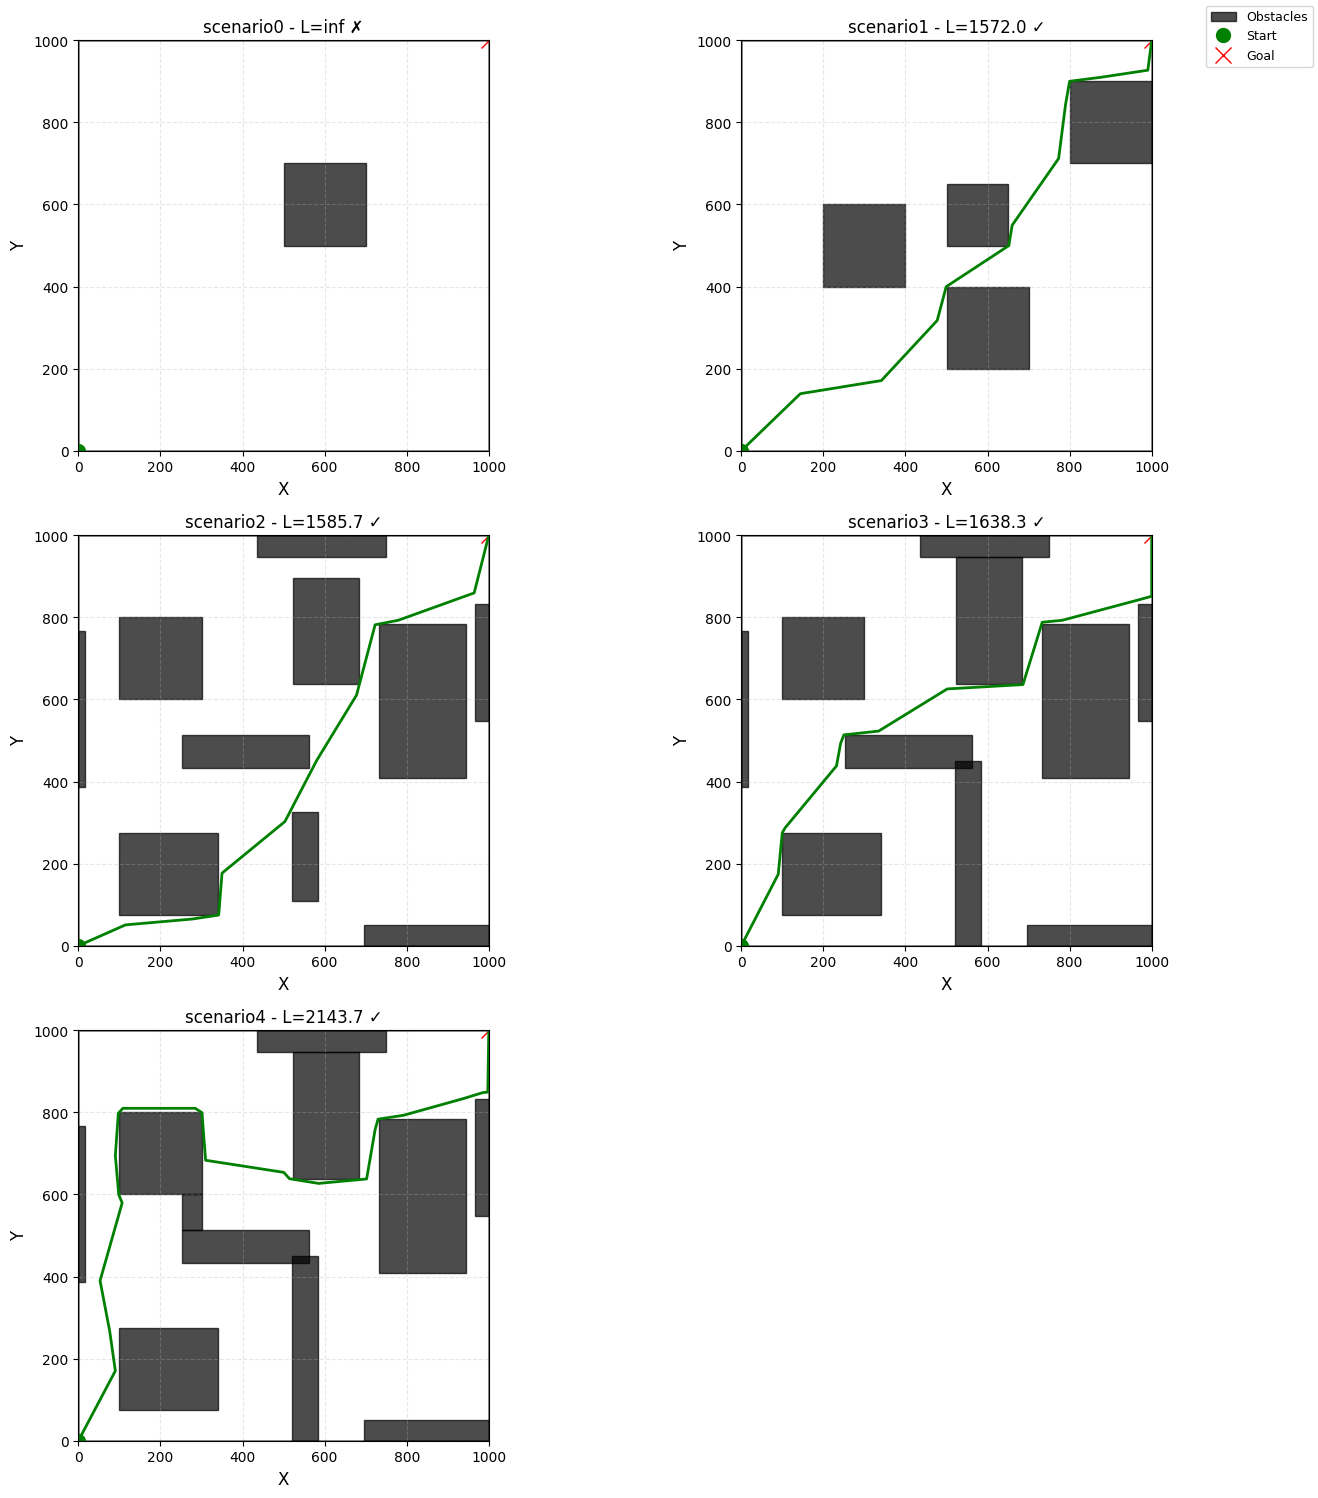

In [35]:
envs = {name: Environment(path) for name, path in SCENARIOS.items()}
benchmark.plot_results_grid(rrt_int_results, envs, n_cols=2)
plt.show()

In [33]:
RRT_PARAMS = {
    'max_iter': 2000,
    'delta_s': 200.0,
    'delta_r': 200.0,
    'goal_bias': 0.05
}

print(f"Benchmark RRT* sur tous les scénarios (max_iter = {RRT_PARAMS["max_iter"]})")
print("="*60)

rrt_opti_int_results = {}
for name, scenario_path in SCENARIOS.items():
    env_test = Environment(scenario_path)
    result = benchmark.run_rrt(env_test, True, True, RRT_PARAMS)
    result.scenario = name
    rrt_opti_int_results[name] = result
    
    valid_str = "✓" if result.is_valid else "✗"
    length_str = f"{result.path_length:.2f}" if result.path_length < float('inf') else "N/A"
    print(f"{name}: Length={length_str}, Valid={valid_str}, Time={result.cpu_time:.3f}s")

Benchmark RRT* sur tous les scénarios (max_iter = 2000)


RRT* intelligent optimized: 100%|██████████| 2000/2000 [00:59<00:00, 33.36it/s]


scenario0: Length=N/A, Valid=✗, Time=45.594s


RRT* intelligent optimized: 100%|██████████| 2000/2000 [00:25<00:00, 77.52it/s] 


scenario1: Length=1449.75, Valid=✓, Time=21.391s


RRT* intelligent optimized: 100%|██████████| 2000/2000 [00:18<00:00, 106.48it/s]


scenario2: Length=1508.20, Valid=✓, Time=14.406s


RRT* intelligent optimized: 100%|██████████| 2000/2000 [00:15<00:00, 126.71it/s]


scenario3: Length=1531.66, Valid=✓, Time=10.688s


RRT* intelligent optimized: 100%|██████████| 2000/2000 [00:08<00:00, 240.96it/s]

scenario4: Length=1959.80, Valid=✓, Time=6.547s


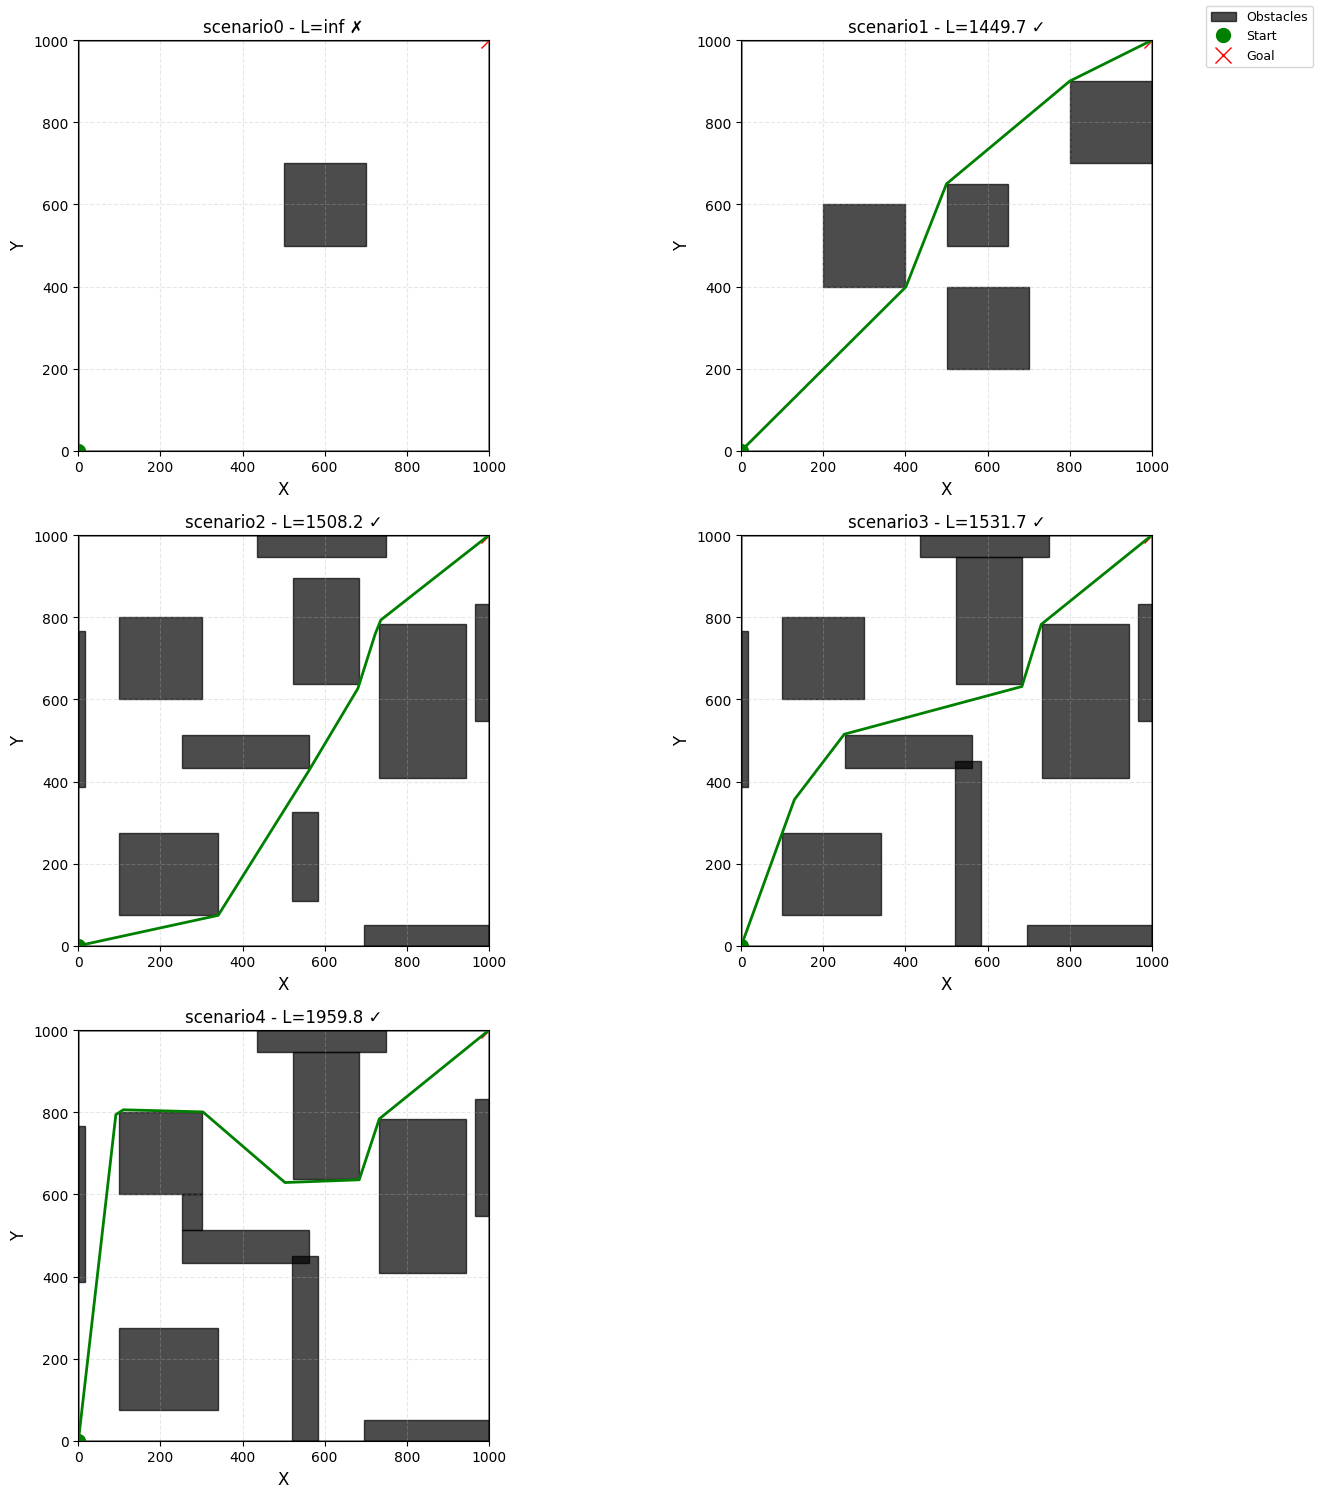

In [36]:
envs = {name: Environment(path) for name, path in SCENARIOS.items()}
benchmark.plot_results_grid(rrt_opti_int_results, envs, n_cols=2)
plt.show()

In [41]:
print("\nComparaison RRT* vs RRT* optim vs RRT* opti int")
print("="*110)
print(f"{'Scénario':<12}  {'RRT Length':>12} {'RRT_op Length':>14} {'RRT_op_int Length':>14} {'RRT Time':>14} {'RRT_op Time':>14} {'RRT_op_int Time':>14}")
print("-"*110)

for name in SCENARIOS.keys():
    rrt_r = rrt_results[name]
    rrt_opti_r = rrt_opti_results[name]
    rrt_opti_int_r = rrt_opti_int_results[name]
    rrt_len = f"{rrt_r.path_length:.2f}" if rrt_r.path_length < float('inf') else "N/A"
    rrt_opti_len = f"{rrt_opti_r.path_length:.2f}" if rrt_opti_r.path_length < float('inf') else "N/A"
    rrt_opti_int_len = f"{rrt_opti_int_r.path_length:.2f}" if rrt_opti_int_r.path_length < float('inf') else "N/A"
    print(f"{name:<12}  {rrt_len:>12} {rrt_opti_len:>14} {rrt_opti_int_len:>14}  {rrt_r.cpu_time:>14.3f} {rrt_opti_r.cpu_time:>14.3f} {rrt_opti_int_r.cpu_time:>14.3f}")


Comparaison RRT* vs RRT* optim vs RRT* opti int
Scénario        RRT Length  RRT_op Length RRT_op_int Length       RRT Time    RRT_op Time RRT_op_int Time
--------------------------------------------------------------------------------------------------------------
scenario0          1446.06        1444.96            N/A          14.984         15.953         45.594
scenario1          1462.85        1459.23        1449.75          13.250         12.938         21.391
scenario2          1525.11        1515.50        1508.20          11.047         10.578         14.406
scenario3          1549.07        1551.02        1531.66           8.672         10.359         10.688
scenario4          1981.32        1998.46        1959.80           8.641          7.938          6.547
